## 1. Configurations

### 1.1. Importing Libs

In [24]:
import numpy as np
import pandas as pd
import os
import warnings
import seaborn as sns

from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap


warnings.filterwarnings('ignore')
%matplotlib inline

### 1.2. Definindo os caminhos

In [18]:
dir_atual = os.path.dirname(os.path.abspath('__file__'))
root_dir = os.path.abspath(os.path.join(dir_atual, '..'))
input_path = os.path.join(dir_atual, 'input')

### 1.3. Lendo o arquivo

In [19]:
df = pd.read_csv(os.path.join(input_path, 'netflix_titles.csv'))

### 1.3. Limpando o arquivo
Vamos limpar os dados onde há valores nulos

In [20]:
df['country'] = df['country'].fillna('No Data')
df['cast'].replace(np.nan, 'No Data',inplace  = True)
df['director'].replace(np.nan, 'No Data',inplace  = True)

df.dropna(inplace=True)
df.drop_duplicates(inplace= True)

df.isnull().sum()

show_id         0
type            0
title           0
director        0
cast            0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
description     0
dtype: int64

### 1.4. Ajustando a data

In [22]:
df['date_added'] = df['date_added'].str.strip()
df['date_added'] = pd.to_datetime(df['date_added'])
df['month_added']=df['date_added'].dt.month
df['month_name_added']=df['date_added'].dt.month_name()
df['year_added'] = df['date_added'].dt.year

df.head(3)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,month_added,month_name_added,year_added
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,No Data,United States,2021-09-25,2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",9,September,2021
1,s2,TV Show,Blood & Water,No Data,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",9,September,2021
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",No Data,2021-09-24,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,9,September,2021


### 1.5. Cores

As cores foram obtidas do próprio [Brand Assets](https://brand.netflix.com/en/assets/logos) da Netflix em:

In [47]:
net_dark = '#101010'
net_red = '#B92028'
net_dark_red = '#B20710'
net_light = '#F5F5F1'

### 1.6. Auxiliares

In [76]:
ratings_ages = {
    'TV-PG': 'Older Kids',
    'TV-MA': 'Adults',
    'TV-Y7-FV': 'Older Kids',
    'TV-Y7': 'Older Kids',
    'TV-14': 'Teens',
    'R': 'Adults',
    'TV-Y': 'Kids',
    'NR': 'Adults',
    'PG-13': 'Teens',
    'TV-G': 'Kids',
    'PG': 'Older Kids',
    'G': 'Kids',
    'UR': 'Adults',
    'NC-17': 'Adults'
}

## 2. Distribuição por conteúdo

Text(1, 0.7, 'N')

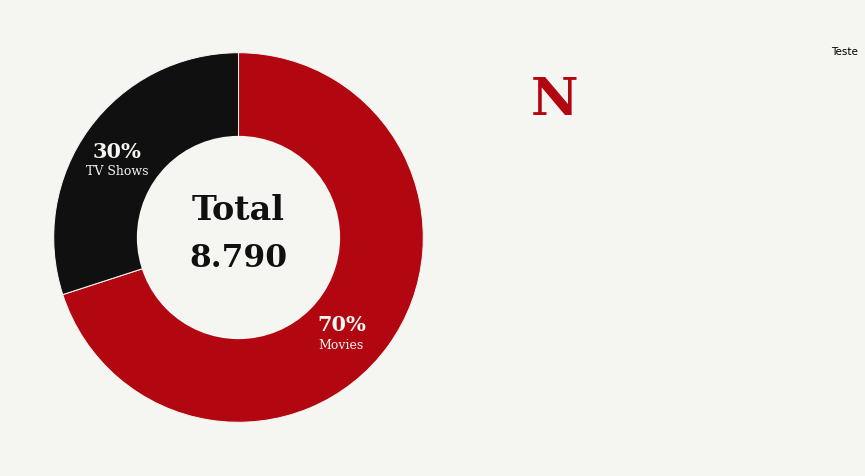

In [170]:


fig, ax = plt.subplots(figsize=(8, 8), dpi=75, facecolor=net_light)
ax.set_facecolor(net_light)

wedges, texts = ax.pie(
    sizes, labels=labels, colors=colors, startangle=90, counterclock=False,
    autopct=None, pctdistance=0.85, wedgeprops={'edgecolor': net_light}
    )

# Criando o "buraco" no meio para formar o donut
centre_circle = plt.Circle((0, 0), 0.55, fc=net_light)
fig.gca().add_artist(centre_circle)

# Removendo o título dos wedges
for text in texts:
    text.set_text('')

for i, wedge in enumerate(wedges):
    angle = (wedge.theta2 + wedge.theta1) / 2  # Calcula o ângulo médio do setor
    x = 0.75 * np.cos(np.radians(angle))  # Converter para coordenada x
    y = 0.8 * np.sin(np.radians(angle))  # Converter para coordenada y

    ax.annotate(
        f'{int(sizes[i] * 100)}%',
        xy=(x-0.05, y),
        ha='center', va='center', 
        fontsize=20, fontfamily='serif', fontweight='bold', color=net_light
    )

    ax.annotate(
        f'{labels[i]}',
        xy=(x-0.052, y-0.11),
        ha='center', va='center', 
        fontsize=12, fontfamily='serif', fontweight='light', color=net_light
    )

ax.annotate(
    text='Total',
    xy=(0,0.15),
    ha='center', va='center', 
    fontsize=32, fontfamily='serif', fontweight='bold', color=net_dark
)

ax.annotate(
    text=f'{total:,.0f}'.replace(",","."),
    xy=(0,-.11),
    ha='center', va='center', 
    fontsize=30, fontfamily='serif', fontweight='bold', color=net_dark
)

fig.text(x=1.5, y=0.8, s='Teste')

fig.text(
    x=1, y=0.7, s='N', 
    fontfamily='serif',fontsize=50, 
    fontweight='bold', color=net_dark_red
)


COLOCAR UM SUBPLOT PARA A ROSCA E PARA O GRAFICO DE TIMELAPSE ONDE MOSTRA A DISTRI
BUICAO DE AMBOS PELOS ANOS


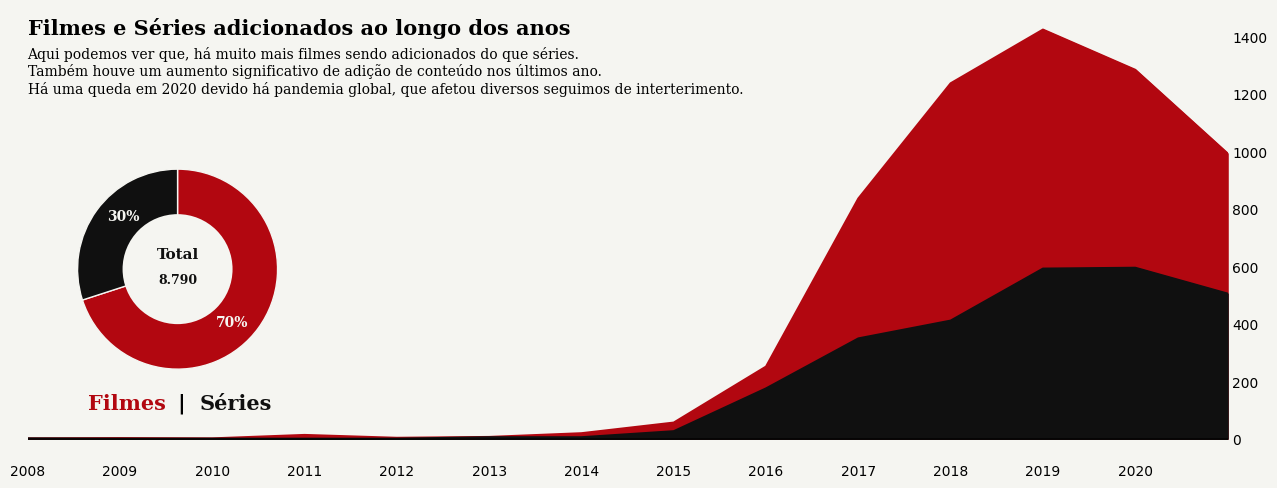

In [285]:
content_group = df.groupby(['type'])['type'].count()

total = int(content_group.sum())    # Total of ocorrences
ratio = (content_group/total).round(2)  # Ratio of each ocorrence
perc = pd.DataFrame(ratio).T    # Transforme in a DataFrame and Transpose

labels = ['Movies', 'TV Shows']
sizes = [perc['Movie'][0], perc['TV Show'][0]]
colors = [net_dark_red, net_dark]


fig = plt.figure(figsize=(15, 5), facecolor=net_light)

ax[0] = fig.add_axes([0.1,0.1,0.8,0.9], facecolor=net_light) # x, y, dx, dy
ax[1] = fig.add_axes([0.05,0.23,0.3,0.5], facecolor=net_light)

wedges, texts = ax[1].pie(
    sizes, labels=labels, colors=colors, startangle=90, counterclock=False,
    autopct=None, pctdistance=0.85, wedgeprops={'edgecolor': net_light}
    )

# Criando o "buraco" no meio para formar o donut
centre_circle = plt.Circle((0, 0), 0.55, fc=net_light)
fig.gca().add_artist(centre_circle)

for i, wedge in enumerate(wedges):
    angle = (wedge.theta2 + wedge.theta1) / 2  # Calcula o ângulo médio do setor
    x = 0.67 * np.cos(np.radians(angle))  # Converter para coordenada x
    y = 0.9 * np.sin(np.radians(angle))  # Converter para coordenada y

    ax[1].annotate(
        f'{int(sizes[i] * 100)}%',
        xy=(x, y),
        ha='center', va='center', 
        fontsize=10, fontfamily='serif', fontweight='bold', color=net_light
    )

# Removendo o título dos wedges
for text in texts:
    text.set_text('')


ax[1].annotate(
    text='Total',
    xy=(0,0.15),
    ha='center', va='center', 
    fontsize=11, fontfamily='serif', fontweight='bold', color=net_dark
)

ax[1].annotate(
    text=f'{total:,.0f}'.replace(",","."),
    xy=(0,-.11),
    ha='center', va='center', 
    fontsize=9, fontfamily='serif', fontweight='bold', color=net_dark
)

# -------------------------------------------------------------------------
# Distribuição temporal

content_group_temp = df.groupby(['year_added', 'type'])['year_added'].count().unstack().reset_index().fillna(0)

ax[0].plot(content_group_temp['year_added'], content_group_temp['Movie'], color=net_dark_red)
ax[0].plot(content_group_temp['year_added'], content_group_temp['TV Show'], color=net_dark)

ax[0].fill_between(content_group_temp['year_added'], 0,content_group_temp['Movie'], color=net_dark_red, alpha=1)
ax[0].fill_between(content_group_temp['year_added'], 0,content_group_temp['TV Show'], color=net_dark, alpha=1)

ax[0].grid(False)
ax[0].set_xlim(2008,2021)
ax[0].set_xticks(np.arange(2008, 2021, 1))
ax[0].yaxis.tick_right()
ax[0].tick_params(axis='both', which='both',length=0)
ax[0].axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .7)
for s in ['top', 'right','bottom','left']:
    ax[0].spines[s].set_visible(False)

fig.text(0.1,0.95, s='Filmes e Séries adicionados ao longo dos anos', fontsize=15, fontweight='bold', fontfamily='serif')
fig.text(
    0.1,0.8, 
    s='''
Aqui podemos ver que, há muito mais filmes sendo adicionados do que séries.
Também houve um aumento significativo de adição de conteúdo nos últimos ano.
Há uma queda em 2020 devido há pandemia global, que afetou diversos seguimos de interterimento.
    ''',
      fontsize=10, fontweight='light', fontfamily='serif')

fig.text(0.14,0.2, s='Filmes', fontsize=15, fontweight='bold', fontfamily='serif', color=net_dark_red)
fig.text(0.2,0.2, s='|', fontsize=15, fontweight='bold', fontfamily='serif', color='black')
fig.text(0.215,0.2, s='Séries', fontsize=15, fontweight='bold', fontfamily='serif', color=net_dark)



plt.show()